In [223]:
from keras.models import load_model

model = load_model('cats_vs_dogs_small_dataset_aug_drop_model2.h5')

In [224]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Next get an input image (a picture of cat) 

In [225]:
img_path = 'C:/Users/Haier/Dataset/dogs-vs-cats/cats_and_dogs_small/test/cats/cat.1700.jpg'

In [226]:
from keras.preprocessing import image 
import numpy as np

In [227]:
img = image.load_img(img_path,target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0)
img_tensor/=255.

print(img_tensor.shape)

(1, 150, 150, 3)


In [228]:
#img_tensor = np.expand_dims(img_tensor,axis=0)
#print(img_tensor.shape)

Displaying test image

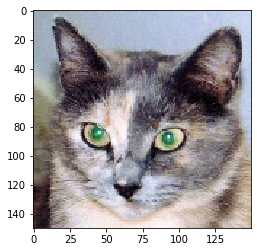

In [229]:
import matplotlib.pyplot as plt 

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps, a Keras model that takes batches of images as input and outputs the activations of all convolution and pooling layers. 

In [230]:
from keras import models


In [231]:
layer_outputs = [layer.output for layer in model.layers[:8]]

In [232]:
layer_outputs

[<tf.Tensor 'conv2d_9_1/Relu:0' shape=(?, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_9_1/MaxPool:0' shape=(?, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_10_1/Relu:0' shape=(?, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_10_1/MaxPool:0' shape=(?, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_11_1/Relu:0' shape=(?, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_11_1/MaxPool:0' shape=(?, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_12_1/Relu:0' shape=(?, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_12_1/MaxPool:0' shape=(?, 7, 7, 128) dtype=float32>]

In [233]:
#for layer in model.layers[:8]:
 #   print(layer.output[0])

In [234]:
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [235]:
activations = activation_model.predict(img_tensor) # returns a list of five Numpy arrays,one array per layer activation

In [236]:
activations[0][0,:,:,0].shape

(148, 148)

In [237]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


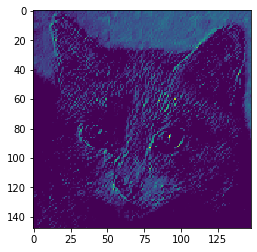

In [238]:
plt.imshow(first_layer_activation[0,:,:,5])
plt.show()

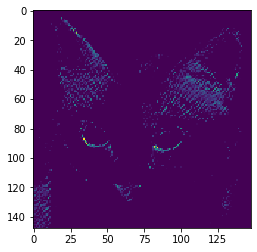

In [239]:
plt.imshow(first_layer_activation[0,:,:,24])
plt.show()

Visualizing every channel in intermediate layer 

In [240]:
# Names of the layer so that you can have them as a part of your plot 
layer_names = []

for layer in model.layers[:8]:
    # print(layer)
    # print(layer.name)
    layer_names.append(layer.name)

In [241]:
layer_names

['conv2d_9',
 'max_pooling2d_9',
 'conv2d_10',
 'max_pooling2d_10',
 'conv2d_11',
 'max_pooling2d_11',
 'conv2d_12',
 'max_pooling2d_12']

In [242]:
a = [4,2,3]
b ={1:'a',2:'b',3:'c'}
c  = [4,5,6]

for i,j in zip(a,c):
    print(i,j)

4 4
2 5
3 6


C:\Rizwan\anaconda3\envs\machine learning\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


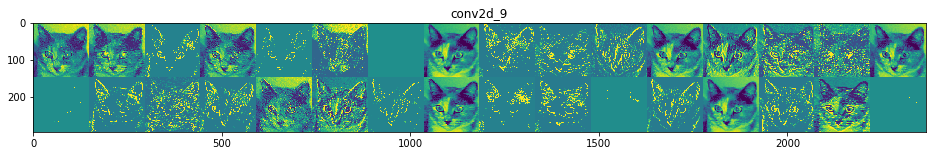

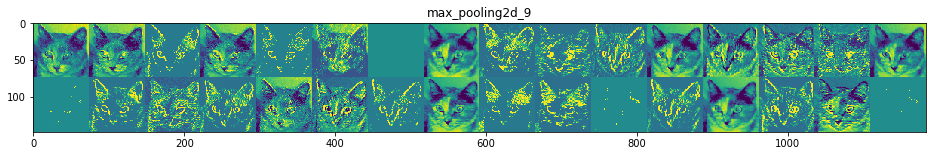

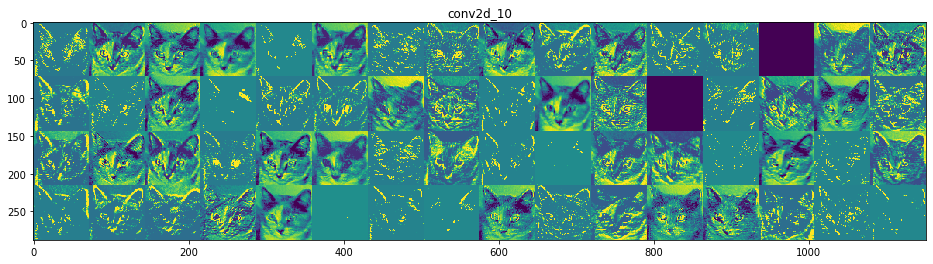

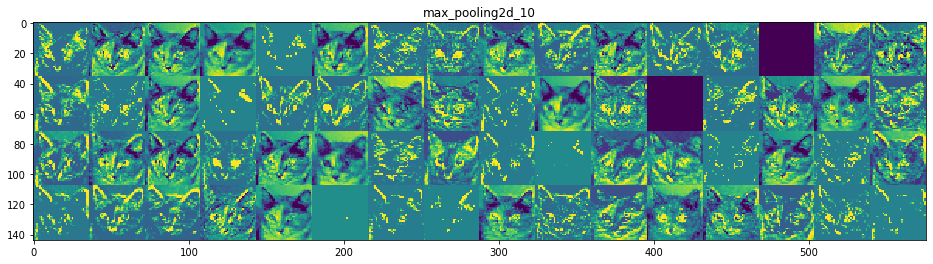

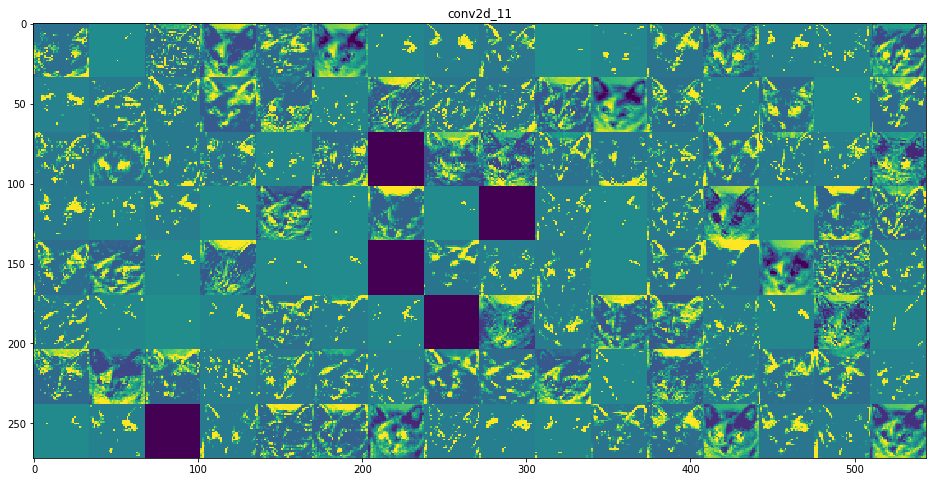

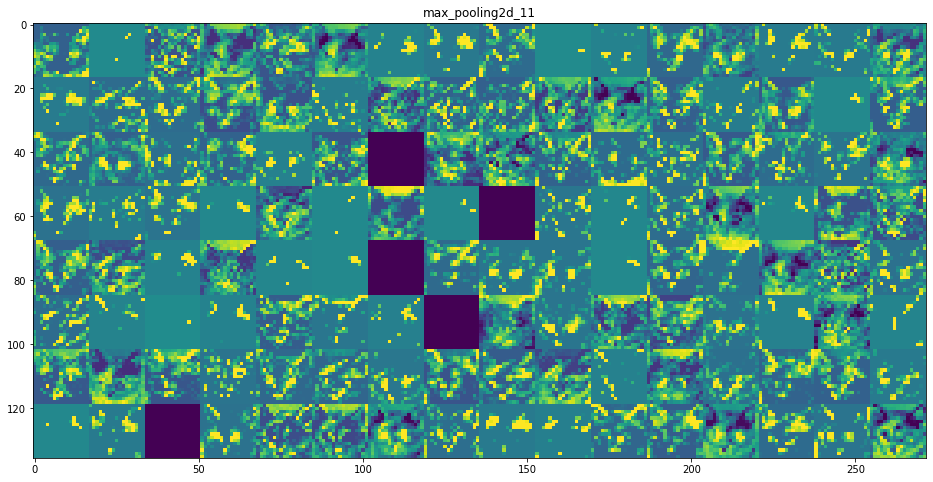

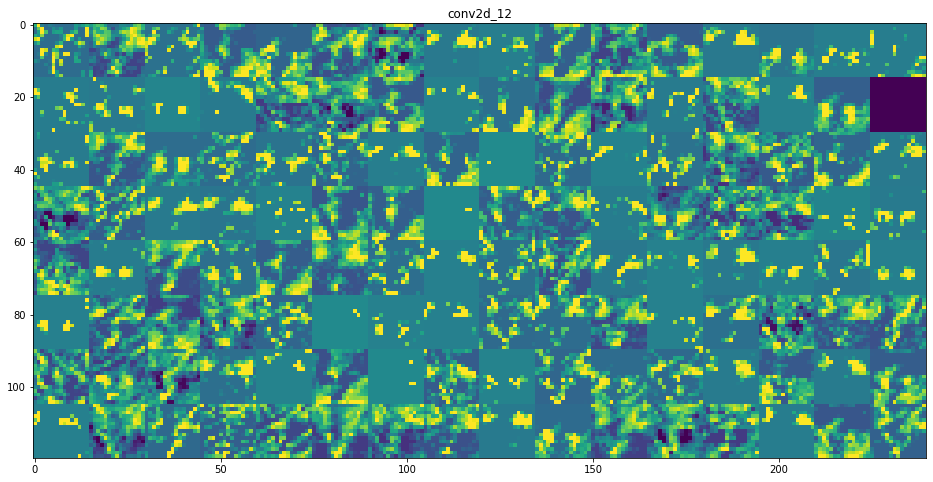

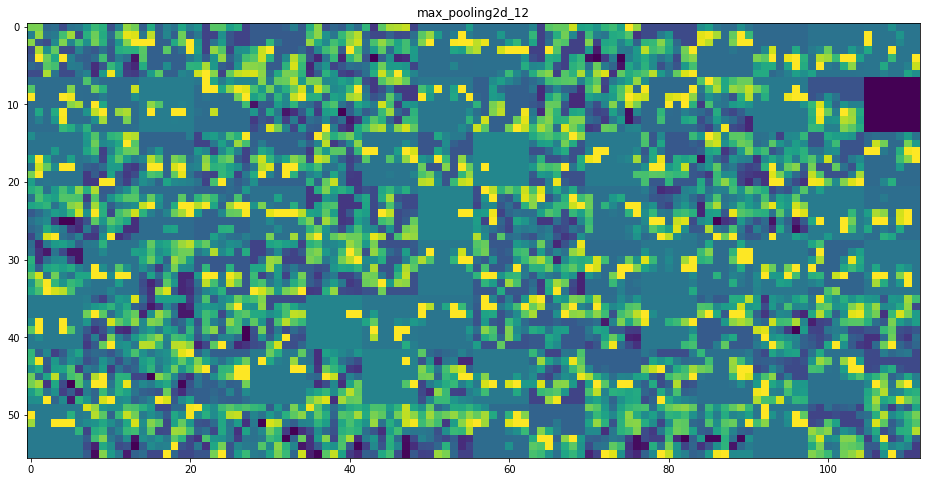

In [243]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):   # display feature maps
    n_features= layer_activation.shape[-1]  # get no. of filters in each conv activation layer
    size = layer_activation.shape[1] #  the feature map has shape(1,size,n_features)
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size*n_cols,images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image= layer_activation[0,:,:,col*images_per_row+row]
            channel_image-=channel_image.mean()
            channel_image/=channel_image.std()
            channel_image*=64
            channel_image+=128
            channel_image=np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size, row*size:(row+1)*size] = channel_image
    scale=1./size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid,aspect='auto',cmap='viridis') 
    plt.savefig('abc.png')

Analysis: 
* The first layer act as collection of various edges, in this layer the activation retain almost all the information of input image 
* The higer activation function have more abstract features that are realted to class label so less information about visual content and have more information related to class
* The more filter in the following layers are blank because the most of information is extarcted in the early layers 

2) Visualizing convnet filters 

In this we inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. 
This can be done with gradient ascent in input space: applying gradient descent to the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input input image. The resulting input image will be one that the chosen filter maximally responsive to. 

In this process we'll build a loss function that maximizes the value of a given filter in a given convolution layer, and then use the value of stochastic gradient to adjust the values of the input image so as to maximize this activation value. 
Consider below the example: loss for activation of filter 0 in the layer block3_conv1 of the VGG16 network,pretrained on ImageNet.

In [244]:
from keras.applications import VGG16
from keras import backend as K

In [245]:
model = VGG16(weights='imagenet',include_top=False)

In [246]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [247]:
layer_name = 'block3_conv1'
filter_index=0

In [248]:
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [249]:
print(layer_output)
print(loss)

Tensor("block3_conv1_1/Relu:0", shape=(?, ?, ?, 256), dtype=float32)
Tensor("Mean_1583:0", shape=(), dtype=float32)


To implement gradient descent,you'll need the gradient of this loss with respect to the model's input. To do this, you'll use the gradients function packaged with the backend module of Keras.

In [250]:
# Gradient of loss function 
grads = K.gradients(loss, model.input)[0]

In [251]:
#print(len(grads))

TypeError: object of type 'Tensor' has no len()

In [252]:
# Noramlize gradient to help gradient-descent process go smoothly
grads/=(K.sqrt(K.mean(K.square(grads)))+1e-5)

In [253]:
# takes a numpy tensor (as a list of tensor of size 1) as input and  returns a list of two numpy tensors: the loss and 
# the gradient value
iterate = K.function([model.input],[loss,grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point, we can define a Python loop to do stochastic gradient descent 

In [254]:
input_img_data = np.random.random((1,150,150, 3))*20+128 # start with a gray image with some noise 

step =1 # magnitude of each gradient update 

for i in range(40):
    loss_value, grad_value = iterate([input_img_data]) # compute loss and gradient value 
    
    input_img_data+= grad_value*step # return gradient for 40 steps 
    

The above resulting tensor image is a floating point tensor of shape (1, 150, 150, 3). with values that may not be integers within [0,255].
Hence to postprocess we use the utility function and return the resulting image.

In [255]:
def deprocess_image(x):
    x-=x.mean()  # normalize in these steps 
    x/=(x.std() + 1e-5)
    x*=0.1
    x+=0.5
    x= np.clip(x,0,1) # clip to [0,1]
    
    x*=255     # convert to rgb array 
    x= np.clip(x,0,255).astype('uint8')
    return x

>> Now we have all pieces. Let's put them together into a Python function that takes as input a layer name and a filter index, and returns a valid image tensor representing the pattern that maximizes the activation of the specified filter 

function to Generate filter visualizations

In [256]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss, model.input)[0] # return gradient with respect to this loss 
    grads/= (K.sqrt(K.mean(K.square(grads)))+1e-5) # normalize the gradient 
    iterate = K.function([model.input],[loss,grads]) # returns the loss and gradient using input image 
    input_img_data = np.random.random((1,size, size, 3))*20+128 # start from a gray image with some noise 
    
    step=1
    for i in range(40): # run the gradient ascent for 40 steps 
        loss_value,grad_value = iterate([input_img_data])
        input_img_data+= grad_value*step 
        
    img = input_img_data[0]
    return deprocess_image(img)

Let's try:

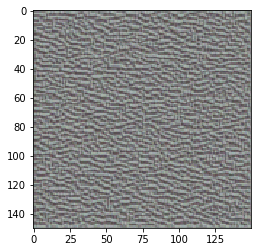

In [257]:
plt.imshow(generate_pattern('block1_conv1',34))

> Analysis: It seems that the filter 0 of block3_conv is responsive to polka-dot pattern. 

Now Plot the filter responsive patterns of first conv layer of each block (64 filters) i.e., block1_conv1, block2_conv2, upto block5_conv1.
Arrange the output on an 8 * 8 grid of 64 * 64 filter patterns, with some black margins between each filter pattern.

Generating a grid of all filter response patterns in a layer 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


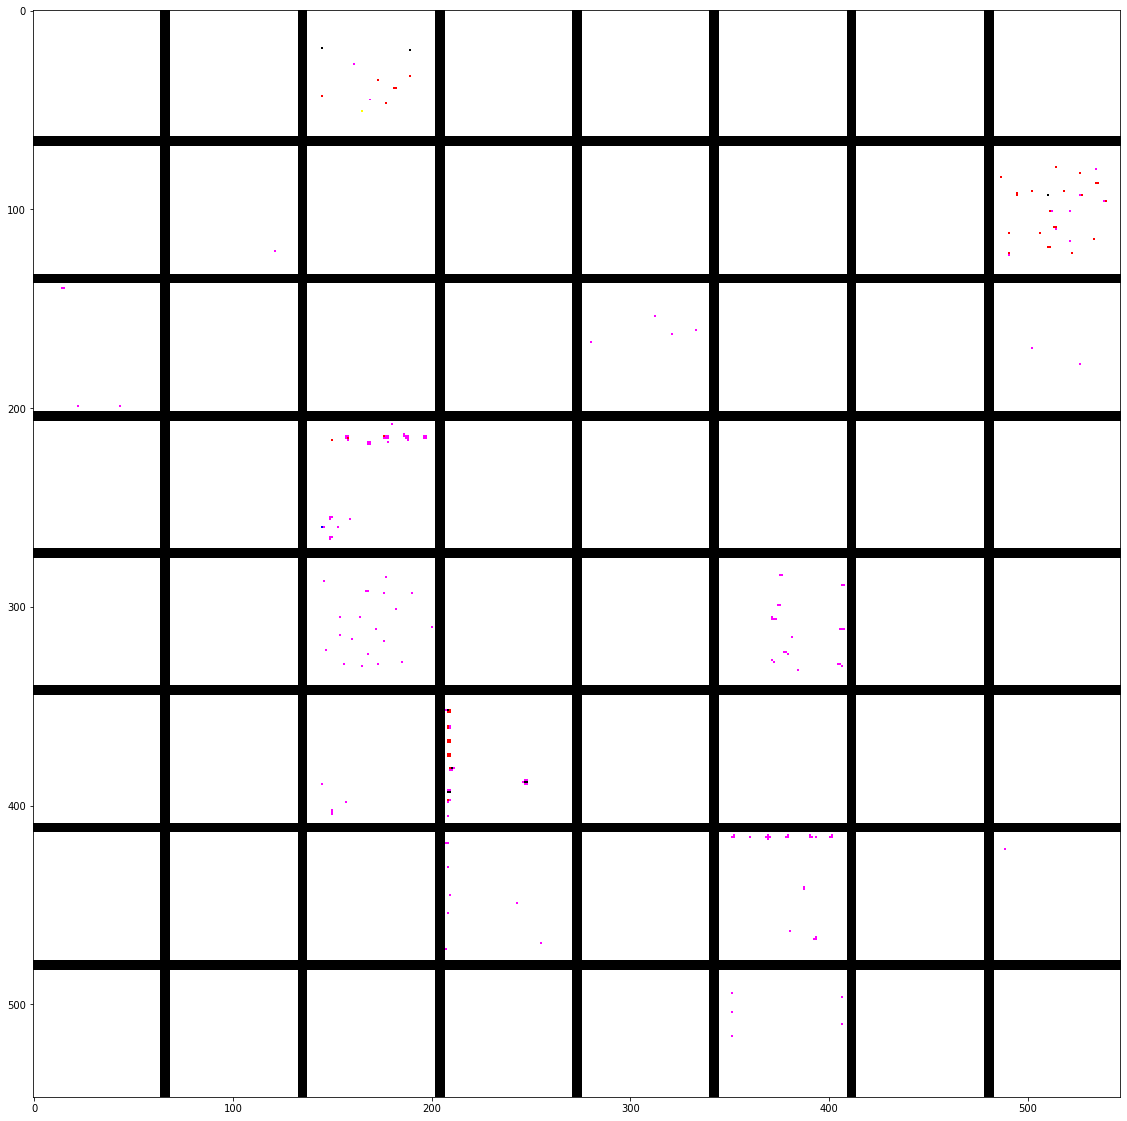

In [258]:
layer_name = 'block3_conv1'
size = 64
margin = 5 

results = np.zeros((8*size+7*margin, 8*size+7*margin,3)) # empty (black) image to store results

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+(j*8),size=size) # genertae the pattern for filter i+(j*8) in layer_name
        
        horizontal_start = i*size+ i*margin  # put the result in the square (i,j) of the results grid 
        horizontal_end = horizontal_start + size
        vertical_start = j*size + j*margin 
        vertical_end = vertical_start+ size
        results[horizontal_start: horizontal_end,vertical_start:vertical_end,:] = filter_img
 


plt.figure(figsize=(20, 20))
plt.imshow(results)        

> Analysis: 
    * The flters from the first layer in the model (block1_conv1) encode simple directional edges and colors 
    * The filter from block2_conv1 encode simple texttures made from combinations of edges and colors
    * The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, ear and so on

3) Class Activation Map Visualization 

By using this technique we can see that which parts of a given image led a convnet to its final classification decision. Its 
helpful to recognize which parts leads to miss-classification. 

It also helpful to locate particular object in an image.

It consists of producing heatmaps of class activation over input image. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location of input image, indicating how important each location is with respect to the class under consideration.   



In [259]:
from keras.applications.vgg16 import VGG16

In [262]:
model = VGG16(weights='imagenet')

In [261]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [263]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np 

In [264]:
img_path = 'C:/Users/Haier/Dataset/Roosterhawaii.jpg'

In [265]:
img = image.load_img(img_path, target_size=(224,224))

In [266]:
import matplotlib.pyplot as plt

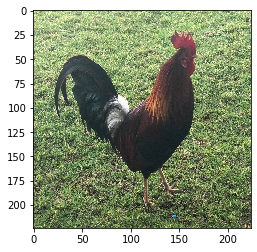

In [267]:
plt.imshow(img)

In [271]:
x = image.img_to_array(img) # float32 numpy array of shape (224,224,3)

In [270]:
x.shape

(224, 224, 3)

In [272]:
x = np.expand_dims(x, axis=0)

In [273]:
x.shape

(1, 224, 224, 3)

In [274]:
x = preprocess_input(x) # color wise channel normalization 

Run the pretrained network on the image and decode its prediction vector to a human-readable format:

In [275]:
preds = model.predict(x)

In [276]:
preds.shape

(1, 1000)

In [278]:
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 1s 15us/step
Predicted: [('n01514668', 'cock', 0.8354137), ('n01514859', 'hen', 0.16265707), ('n01807496', 'partridge', 0.0010414519)]


In [279]:
np.argmax(preds[0])

7

Setting up the Grad-CAM algorithm 

In [281]:
cock_output = model.output[:,7]
last_conv_layer = model.get_layer('block5_conv3')  #output feature map 

In [283]:
grads = K.gradients(cock_output,last_conv_layer.output)[0]

In [284]:
grads.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(512)])

In [287]:
pooled_grads = K.mean(grads, axis=(0,1,2)) # vector of shape 512 where each entry is the mean intensity of the gradient over
# a specific feature-map channel

In [288]:
pooled_grads.shape

TensorShape([Dimension(512)])

In [292]:
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]]) # access the values of the quantities you 
# just defined: pooled_grads and the outut feature map of block5_conv3, given a sample image 

pooled_grads_value, conv_layer_output_value = iterate([x]) # values of these two quantities as numpy array, given the input
# image 

In [293]:
for i in range(512):
    conv_layer_output_value[:,:,i]*= pooled_grads_value[i] # multiplies each channel in the feature-map array by ''how 
    # important this channel is "with respect to the cock class" 
heatmap = np.mean(conv_layer_output_value, axis=-1) # channel wise mean of the resulting feature map is the heatmap of the 
# class activation 

In [295]:
heatmap.shape

(14, 14)

Normalize the heatmap between 0 and 1 before visualization 

In [298]:
# Heatmap post-processing
heatmap=np.maximum(heatmap,0)
heatmap/= np.max(heatmap)

In [299]:
heatmap.shape

(14, 14)

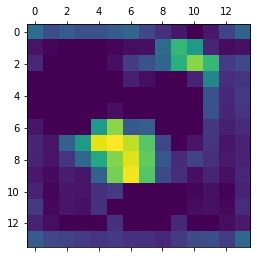

In [300]:
plt.matshow(heatmap)

#### Finaly use opencv to generate an image that superimposes the orignal image on the heatmap.

In [302]:
# superimposing the heatmap with the orignal picture

import cv2
img = cv2.imread(img_path) # use cv2 to load the orignal image
heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0])) # resize the heatmap to the same size as the input image 
heatmap = np.uint8(255*heatmap) # convert the heatmap to RGB 
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET) # apply heatmap to the orignal image 
superimposed_img = heatmap*0.4 + img # 0.4 is the heatmap intensity factor 
cv2.imwrite('C:/Users/Haier/Dataset/cock_cam.jpg',superimposed_img) # saves the image to disk 

True

In [303]:
img_path_cam = 'C:/Users/Haier/Dataset/cock_cam.jpg'
img_cam = cv2.imread(img_path_cam)

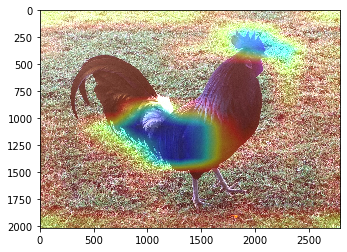

In [306]:
plt.imshow(img_cam)

> Analysis: This visualization technique answers two important questions:
* Why did the network think this image contained a cock 
* Where is the cock located in the picture 

> The top of the head part is more activated because that may be help to differntiate between cock and hen 

### Chapter Summary: 
* Convnets are the best tool for takling visual classification problem 
* Convnets work by learning a hierarchy of modular patterns and concepts to represent visual world
* The representation they learn are easy to inspect 
* we can use augmentation to fight overfitting 
* we can use fine-tuning to enhance performance on small dataset 
* We can generate visualizations of the filters learned by convnets as well as heatmaps of the class activity  

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< End >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>